In [1]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from Model import Actor, Critic
from VecEnv import EIEnv

In [2]:
env=EIEnv(gamma=0.95)

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
actor_net = Actor(env.observation_space.shape[0],16)
critic_net = Critic(env.observation_space.shape[0],17)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_net = actor_net.to(device)
critic_net = critic_net.to(device)
checkpoint = torch.load('./models/best')
actor_net.load_state_dict(checkpoint['actor_model_state_dict'],strict=False)
critic_net.load_state_dict(checkpoint['critic_model_state_dict'],strict=False)
actor_net.eval()
critic_net.eval()

Critic(
  (values): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=17, bias=True)
  )
)

In [4]:
import torch.distributions as dist
import numpy as np
gamma=0.95
np.random.seed(1)
steps=np.zeros([1438,20])
T_in = np.zeros([1438,10])
values = np.zeros(1438)
costs_all = []
actions = np.zeros([1438,16])
mus=np.zeros([1438,16])
sigmas=np.zeros([1438,16])
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1438)):
        observation_in=env.observation_scalar(observation)
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        mu, sigma = actor_net(observation_in)
        values = critic_net(observation_in)
        normal_probs = dist.normal.Normal(mu,sigma+1e-1)
        action = normal_probs.sample()      
        action = action.detach().cpu().numpy()[0]
        # gather env data, reset done envs and update their obs
        observation, costs, _, _= env.step(action)
        T_in[step] = env.T_in
        steps[step]=observation
        actions[step]=action
        mus[step]=mu.detach().cpu().numpy()[0]
        sigmas[step]=sigma.detach().cpu().numpy()[0]
        costs_all.append(costs)

In [17]:
import torch.distributions as dist
import numpy as np
gamma=0.95
np.random.seed(1)
steps=np.zeros([1438,20])
T_in = np.zeros([1438,10])
values = np.zeros(1438)
costs_all = []
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1438)):
        observation_in=env.observation_scalar(observation)
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        mu, sigma = actor_net(observation_in)
        values = critic_net(observation_in)
        actions = mu   
        # gather env data, reset done envs and update their obs
        observation, costs, _, _= env.step(actions.detach().cpu().numpy()[0])
        T_in[step] = env.T_in
        steps[step]=observation
        costs_all.append(costs)

In [5]:
costs_all = np.array(costs_all)

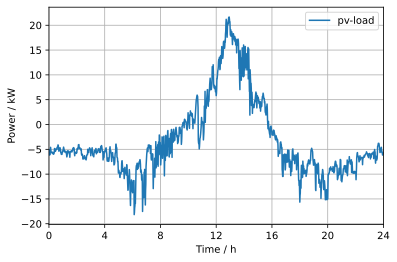

In [6]:
#obs: t[0], P_PV-PLsum[1], P_G[2], SOC[3], T_out[4] E_EV[5:5+M], AC_open_time[-N:]
plt.plot(steps[:,0], steps[:,1], label='pv-load')
#plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
#plt.ylim(0,100)
plt.xlim(0,24)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

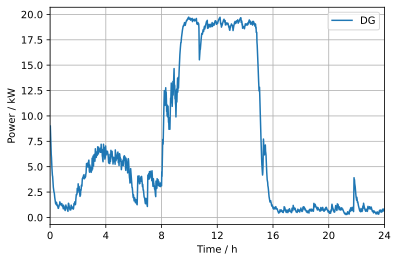

In [7]:
plt.plot(steps[:,0], steps[:,2], label='DG')
plt.xlim(0,24)
#plt.ylim(0,10)
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

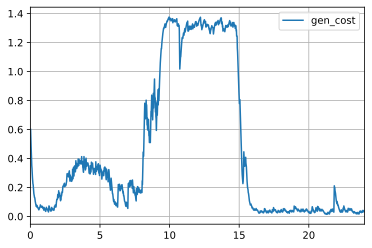

In [8]:
plt.plot(steps[:,0], costs_all[:,0], label='gen_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

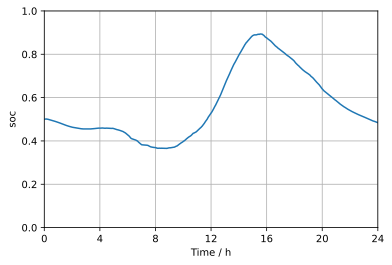

In [9]:
plt.plot(steps[:,0], steps[:,3])
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

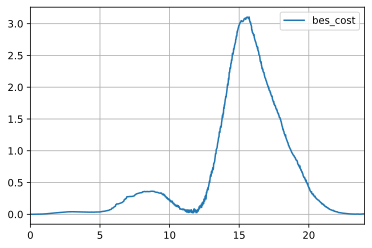

In [10]:
plt.plot(steps[:,0], costs_all[:,1], label='bes_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

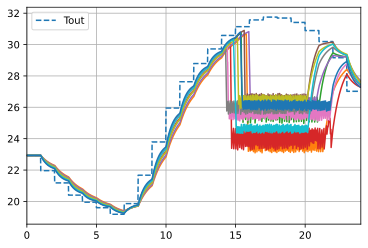

In [11]:
plt.plot(steps[:,0],steps[:,4], '--', label='Tout')
for i in range(10):
    plt.plot(steps[:,0],T_in[:,-(i+1)])
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

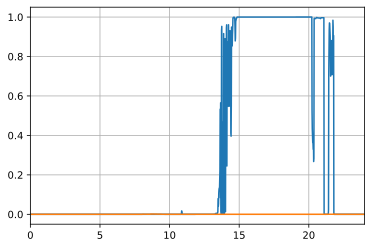

In [12]:
n=5
#for i in range(10):
plt.plot(steps[:,0],mus[:,6+n])
plt.plot(steps[:,0],sigmas[:,6+n])
plt.xlim(0,24)
plt.grid()
#plt.legend()
plt.show()

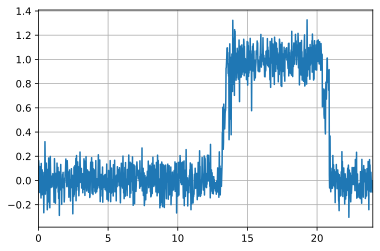

In [13]:
n=3
#for i in range(10):
plt.plot(steps[:,0],actions[:,6+n])
plt.xlim(0,24)
plt.grid()
#plt.legend()
plt.show()

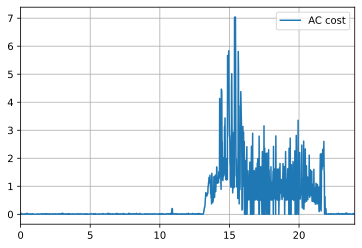

In [14]:
plt.plot(steps[:,0],np.sum(costs_all[:,-10:],axis=1), label='AC cost')
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

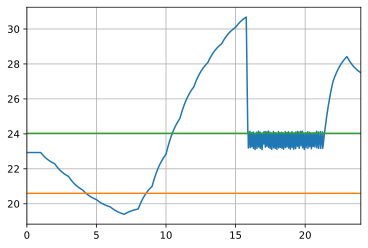

In [25]:
n=9
plt.plot(steps[:,0],T_in[:,n])
plt.plot(steps[:,0], env.Tlower[n]*np.ones(1438), label='Tlower')
plt.plot(steps[:,0], env.Tupper[n]*np.ones(1438), label='Tupper')
plt.xlim(0,24)
plt.grid()
plt.show()

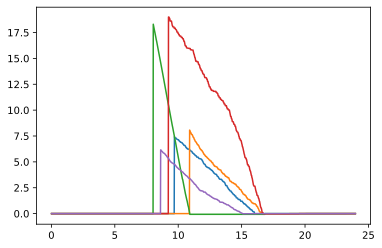

In [26]:
M = 5
for i in range(M):
    plt.plot(steps[:,0],steps[:,5+i])

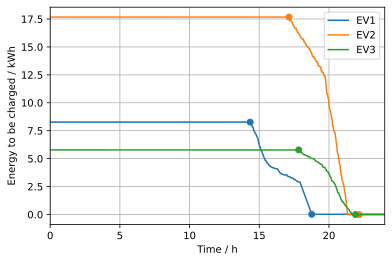

In [12]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(env.start_charge_time[0],steps[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(env.start_charge_time[10],steps[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps[-1,16],'C1o')
plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
plt.plot(env.start_charge_time[15],steps[0,21],'C2o')
plt.plot(env.end_charge_time[15],steps[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.ylabel('Energy to be charged / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/EV.svg',format='svg')
plt.show()

In [7]:
np.random.seed(100)
steps_compare=np.zeros([1438,76])
AC_action = np.zeros([30])
observation = env.reset()
for step in range(int(1438)):
    Tin = env.state[-30:] 
    for i in range(30):
        #若不在控制时间内，保持控制信号为0
        if env.AC_sign[i]==True:
            if Tin[i]>=env.Tupper[i]+3:
                AC_action[i] = 1
            elif Tin[i]<=env.Tlower[i]-3:
                AC_action[i] = 0
    actions = np.concatenate(([0],np.ones(20),AC_action), axis=0)
    # gather env data, reset done envs and update their obs
    observation, gen_cost, bes_cost, AC_cost, _, _= env.step(actions)
    #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
    steps_compare[step]=env.state

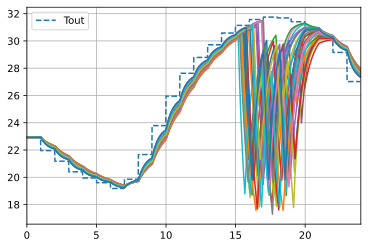

In [8]:
plt.plot(steps_compare[:,0],steps_compare[:,5], '--', label='Tout')
for i in range(30):
    plt.plot(steps_compare[:,0],steps_compare[:,-(i+1)])
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

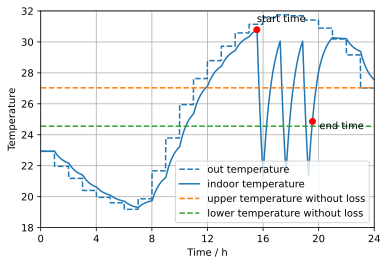

In [22]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], '--', label='out temperature')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C0', label = 'indoor temperature')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C1--' ,label='upper temperature without loss')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--', label='lower temperature without loss')
plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.xlim(0,24)
plt.ylim(18,32)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

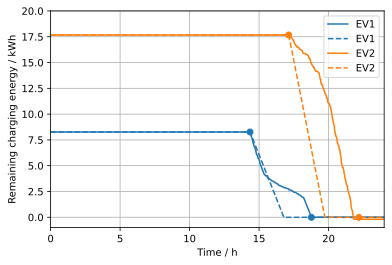

In [43]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(steps_compare[:,0],steps_compare[:,6], 'C0--', label='EV1')
plt.plot(env.start_charge_time[0],steps_compare[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps_compare[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(steps_compare[:,0],steps_compare[:,6+10], 'C1--', label='EV2')
plt.plot(env.start_charge_time[10],steps_compare[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps_compare[-1,16],'C1o')
#plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
#plt.plot(steps_compare[:,0],steps_compare[:,6+15],'C2--', label='EV3')
#plt.plot(env.start_charge_time[15],steps_compare[0,21],'C2o')
#plt.plot(env.end_charge_time[15],steps_compare[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.ylim(-1,20)
plt.ylabel('Remaining charging energy / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/EV.svg',format='svg')
plt.show()

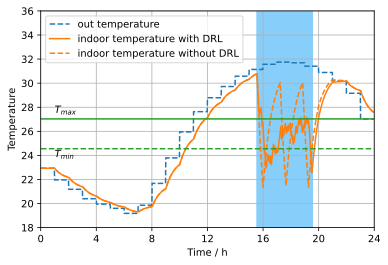

In [42]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], 'C0--', label='out temperature')
plt.plot(steps[:,0],steps[:,-(30-n)], 'C1', label = 'indoor temperature with DRL')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C1--', label = 'indoor temperature without DRL')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C2')
plt.text(1, env.Tupper[n]+0.5, '$T_{max}$')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--')
plt.text(1, env.Tlower[n]-0.7, '$T_{min}$')
#plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
#plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
#plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
#plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.fill_between(np.linspace(env.start_AC_time[n],env.end_AC_time[n],100),18*np.ones(100), 36*np.ones(100),color='lightskyblue')
plt.xlim(0,24)
plt.ylim(18,36)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

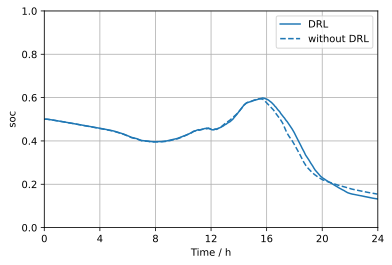

In [34]:
plt.plot(steps[:,0], steps[:,3], 'C0', label='DRL')
plt.plot(steps_compare[:,0], steps_compare[:,3], 'C0--', label='without DRL')
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

In [45]:
import numpy as np
result = []
for i in range(5):
    result.append(np.zeros(3))
result = np.array(result).reshape(-1,1)

In [46]:
result

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])